# Monitoring Extreme U.S. Temperatures: July 2022 Heatwave

Production date: 09-10-2025

Produced by: Amaya Camila Trigoso Barrientos (VUB)

## 🌍 Use case: Using monthly temperature anomalies to detect and monitor heatwave conditions in the United States.

## ❓ Quality assessment question
 **Can ERA5-Land monthly-averaged 2 m temperature data reliably detect extreme temperature events documented in the literature, such as the July 2022 U.S. heatwave, and are these results consistent with observation-based datasets like NOAA’s NClimGrid?**

[ERA5-Land monthly averaged data (1950–present)](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land-monthly-means?tab=overview) is a reanalysis dataset available from the Climate Data Store (CDS). It features a regular spatial resolution on a latitude/longitude grid of 0.1° x 0.1° (native resolution: 9 km). The dataset provides monthly averaged and hourly averaged by month data for various parameters. It includes 31 instantaneous parameters, one of which is the 2-meter air temperature, often called air temperature. This parameter is particularly valuable for climate monitoring, including the tracking of extreme temperature events such as heatwaves.

The summer of 2022 witnessed a significant heatwave across the United States, characterized by a prolonged period of elevated temperatures and intensified drought conditions. This compound drought-heatwave event was notably pronounced in the western and central regions, including Texas, and was influenced by varying land-atmosphere coupling mechanisms [[1]](https://doi.org/10.1016/j.wace.2024.100722).

The goal of this quality assessment is to evaluate whether the ERA5-Land dataset can effectively capture extreme temperature events documented in the literature. As a case study, we focused on the July 2022 heatwave in the United States. To validate ERA5-Land 2 m temperature results, we compared them with observations from the NOAA Monthly U.S. Climate Gridded Dataset (NClimGrid). Although the heatwave persisted across multiple months, July was selected for this analysis to maintain focus and brevity, particularly since Texas experienced pronounced temperature extremes during this period.

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* ERA5-Land monthly-averaged 2 m temperature data captured the extreme temperature event of July 2022 in the U.S., as evidenced by strong spatial agreement with NOAA’s NClimGrid anomalies.
* During heatwave events, average temperatures across the contiguous United States and in Texas show that ERA5-Land values are slightly higher than those of NClimGrid, likely because ERA5-Land accounts for all hours of the day, whereas NClimGrid computes averages only from daily maximum and minimum temperatures.
```

## 📋 Methodology

Monthly 2-meter temperature data from ERA5-Land were downloaded for 1991–2024 and spatially clipped to the contiguous United States. Temperature anomalies for July 2022 were calculated relative to the 1991–2020 climatological mean. The anomalies were mapped and visually compared to the NOAA NClimGrid dataset to assess consistency. Spatial mean temperatures were also computed for the contiguous U.S. and Texas for selected months and compared to values published in NOAA's Montly Climate to validate the results.

**[](section-1)**
 * Download monthly averaged 2-meter temperature from the ERA5-Land monthly means dataset for the period 1991–2024.
 * Select the spatial domain covering the contiguous United States.

**[](section-2)**
 * Clip the ERA5-Land data to the U.S. boundary.
 * Calculate temperature anomalies for July 2022 relative to the 1991–2020 July climatological mean.
 * Visualize the anomalies on a map of the contiguous United States.
 * Compare the anomaly patterns visually with the corresponding NClimGrid dataset.

**[](section-3)**
 * Compute the mean spatial temperature for: July 2022 across the contiguous United States, July 2022 in Texas and August 2011 in Texas.
 * Compare the results to official NOAA values.
 * Analyse the results.

## 📈 Analysis and results

(section-1)=
### 1. Request and download data

#### Import packages

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import fsspec
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
import pymannkendall as mk
import shapely.geometry
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download, plot
import os
from shapely.ops import unary_union
import cartopy.io.shapereader as shpreader
from shapely.geometry import Polygon
os.environ["CDSAPI_RC"] = os.path.expanduser("~/trigoso_camila/.cdsapirc")
plt.style.use("seaborn-v0_8-notebook")

#### Set the data request

In [29]:
year_start = 1991
year_stop = 2024

collection_id = "reanalysis-era5-land-monthly-means"

request = {
    "product_type": "monthly_averaged_reanalysis",
    "variable": "2m_temperature",
    "year": [str(year) for year in range(year_start, year_stop + 1)],
    "month": [f"{month:02d}" for month in range(1, 13)],
    "time": "00:00",
    "data_format": "grib",
    "download_format": "zip",
    "area": [49, -125, 24, -66],
}

#### Download data

In [30]:
ds = download.download_and_transform(collection_id, request, chunks={"year": 1})

100%|██████████| 34/34 [00:01<00:00, 17.01it/s]


Convert temperature to °F.

In [4]:
da = ds["t2m"]
with xr.set_options(keep_attrs=True):
    da = (da - 273.15) * 9/5 + 32  # Convert Kelvin to Fahrenheit
da.attrs["units"] = "°F"

(section-2)=
### 2. Temperature anomalies nationwide

Clip data to the contiguous USA area.

In [5]:
# --- Load U.S. states shapefile (TIGER 2023) ---
url = "https://www2.census.gov/geo/tiger/TIGER2023/STATE/tl_2023_us_state.zip"
gdf = gpd.read_file(url)
gdf = gdf[~gdf['STUSPS'].isin(['AK', 'HI', 'PR', 'GU', 'VI', 'MP', 'AS'])]

# --- Load Natural Earth lake polygons ---
lakes_shp = shpreader.natural_earth(resolution='10m', category='physical', name='lakes')
lakes = gpd.read_file(lakes_shp)

# --- Filter only the Great Lakes ---
great_lakes_names = ['Lake Superior', 'Lake Michigan', 'Lake Huron', 'Lake Erie', 'Lake Ontario']
great_lakes = lakes[lakes['name'].isin(great_lakes_names)]
great_lakes_union = unary_union(great_lakes.geometry)

# --- Subtract Great Lakes from state polygons ---
gdf['geometry'] = gdf['geometry'].apply(lambda geom: geom.difference(great_lakes_union))

# Ensure your DataArray has a CRS
da = da.rio.write_crs("EPSG:4326", inplace=False)

# Convert GeoDataFrame geometries to a list
state_geoms = gdf.geometry.values.tolist()

# Mask the raster using the states without lakes
da_clipped = da.rio.clip(state_geoms, gdf.crs, drop=False, invert=False)

#### Anomalies calculation

Calculate temperature anomalies for July 2022 in relation to the baseline 1991-2020.

In [6]:
# Extract July 2022
da_july_2022 = da_clipped.sel(forecast_reference_time="2022-07-01")

# Baseline calculation 
def compute_time_weighted_mean(da, month, start_year, end_year):
    
    # Filter the data by the specified month and year range
    da_filtered = da.sel(
        forecast_reference_time=da.forecast_reference_time.where(
            (da.forecast_reference_time.dt.month == month) &
            (da.forecast_reference_time.dt.year >= start_year) &
            (da.forecast_reference_time.dt.year <= end_year),
            drop=True
        )
    )
    return da_filtered

# Baseline 1991-2020
da_baseline_91_20 = compute_time_weighted_mean(da_clipped, 7, 1991, 2020)
da_baseline_91_20_mean = diagnostics.time_weighted_mean(da_baseline_91_20)
# Anomalies calculation
da_anomalies_91_20 = da_july_2022 - da_baseline_91_20_mean

#### Plot anomalies nationwide

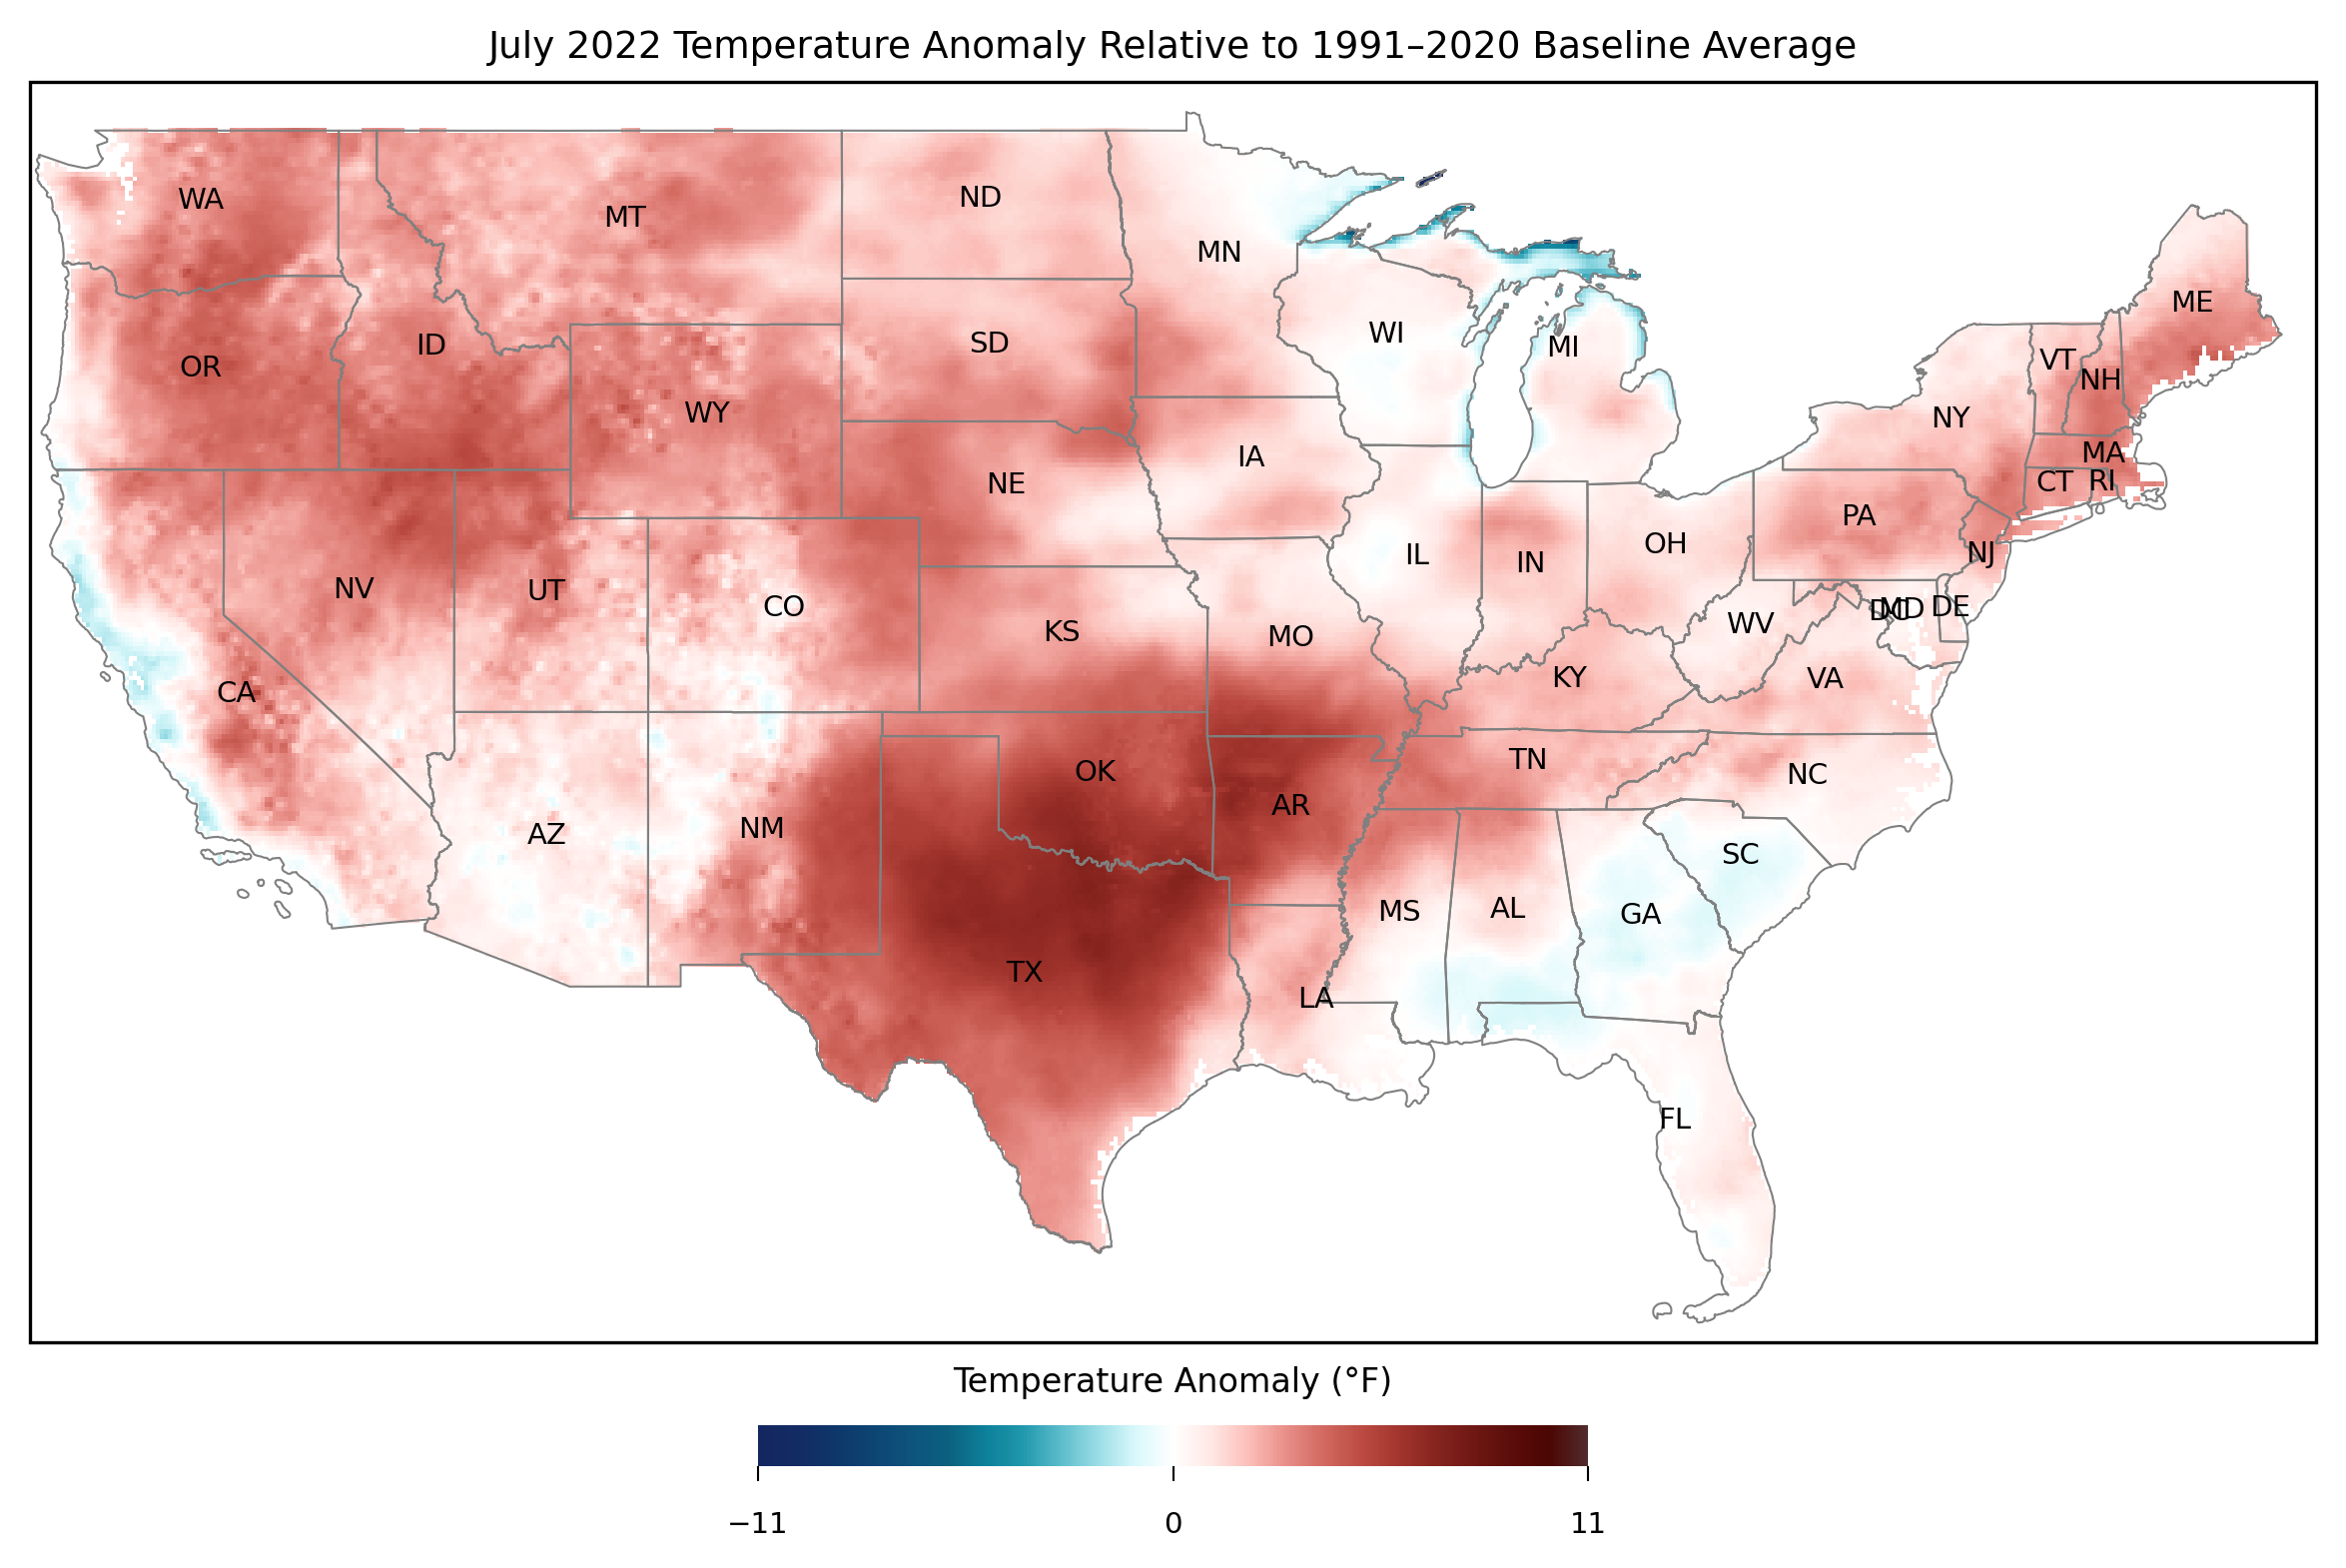

In [7]:
#Define your custom color map exactly as before
colors = {
    -11: "#142660",
    -10: "#132B63",
    -9:  "#0E3669",
    -8:  "#0D4473",
    -7:  "#0D537C",
    -6:  "#0C607E",
    -5:  "#0D809A",
    -4:  "#1F97AC",
    -3:  "#5BBCCB",
    -2:  "#9ADDE6",
    -1:  "#D9F8FB",
     0:  "#FFFFFF",
     1:  "#FFE8E5",
     2:  "#FCBFB9",
     3:  "#E88F88",
     4:  "#D26960",
     5:  "#BC4C43",
     6:  "#A2352E",
     7:  "#86241E",
     8:  "#6F1814",
     9:  "#5A0D0A",
    10:  "#4C0604",
    11:  "#512B2B"
}
norm = mcolors.Normalize(vmin=-11, vmax=11)
color_positions = [(norm(k), v) for k, v in sorted(colors.items())]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_diverging", color_positions)

#Plot
fig, ax = plt.subplots(figsize=(10, 6), dpi=300, subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the temperature anomalies DataArray (replace this with your actual xarray DataArray)
temperature_plot = da_anomalies_91_20.plot.imshow(
    ax=ax, cmap=custom_cmap, add_colorbar=False, vmin=-11, vmax=11
)

# Focus on CONUS
ax.set_extent([-125, -66, 24, 50], crs=ccrs.PlateCarree())

# Plot shapefile outlines
gdf.plot(ax=ax, facecolor='none', edgecolor='grey', linewidth=0.5, transform=ccrs.PlateCarree())

# Add state abbreviations
for _, row in gdf.iterrows():
    centroid = row.geometry.centroid
    ax.text(
        centroid.x, centroid.y, row['STUSPS'],
        fontsize=7, ha='center', transform=ccrs.PlateCarree()
    )

# Title and labels
ax.set_title("July 2022 Temperature Anomaly Relative to 1991–2020 Baseline Average", fontsize=9)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Colorbar
cbar = plt.colorbar(temperature_plot, ax=ax, orientation='horizontal', fraction=0.03, pad=0.06)
cbar.set_label('Temperature Anomaly (°F)', fontsize=8, rotation=0, labelpad=8)
cbar.outline.set_visible(False)
cbar.ax.tick_params(width=0.5)
cbar.set_ticks([-11, 0, 11])
cbar.ax.tick_params(labelsize=7)
cbar.ax.xaxis.set_label_position('top')

plt.show()


*Figure 1. July 2022 2-meter temperature anomaly (°F) relative to 1991–2020 baseline, calculated using the ERA5-Land dataset.*

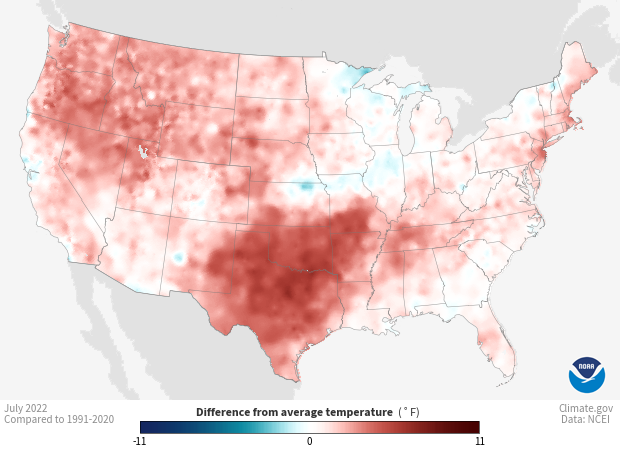

*Figure 2. July 2022 average temperature anomaly (°F) relative to 1991–2020 baseline produced by NOAA using NClimGrid. Source: NOAA (Download Directories), 2022 [[2]](https://www.climate.gov/data/Temperature--Monthly--Difference-from-average--CONUS/01-small/Temperature--Monthly--Difference-from-average--CONUS--2022-07-00--small.png).*

In general, the temperature anomalies shown in Figures 1 and 2 are quite similar. Both indicate a major positive anomaly in average temperature across Texas, Oklahoma, and parts of Arkansas, Missouri, and Kansas during July 2022. Most of the rest of the country also experienced positive anomalies, though of smaller magnitude than in those states.

Some regional differences appear between Figures 1 and 2, particularly in areas with slight negative anomalies. In South Carolina, Georgia, and Alabama, ERA5-Land shows a slight negative anomaly, while NClimGrid depicts near-normal conditions (white). The negative anomalies along the California coast and around the Great Lakes are more pronounced with ERA5-Land than with NClimGrid. Conversely, northern Kansas, Missouri, and Illinois display a negative anomaly in Figure 2 (NClimGrid), whereas Figure 2 (ERA5-Land) shows temperatures closer to normal in those areas.

Differences between the two datasets are expected, as ERA5-Land and NClimGrid obtain temperature information in fundamentally different ways. ERA5-Land is a reanalysis product that uses ERA5 atmospheric data as forcing but runs the land surface model at a higher spatial resolution. It does not assimilate observations directly, yet it benefits indirectly from ERA5's data assimilation of various atmospheric variables used in the forcing fields.

In contrast, the NOAA Monthly U.S. Climate Gridded Dataset (NClimGrid) is an observational product derived from temperature and precipitation measurements in the Global Historical Climatology Network–Daily (GHCN-D). The second version of NClimGrid incorporates data from 10,325 temperature and 14,702 precipitation stations across the contiguous United States. The dataset is produced on a 5 × 5 km grid, where missing grid cells are filled using a climatologically aided interpolation.

The climatologically aided interpolation requires the calculation of three main grids:

i) Normal grid: A baseline grid of climate normals (long-term averages) is generated for each station, month, and variable. These normals are then interpolated to the 5 km grid using a thin-plate smoothing spline method.

ii) Anomaly grid: Anomalies are calculated for each station, year, and month relative to the corresponding climate normal. The resulting anomalies are interpolated to the grid using inverse-distance weighting.

iii) Composite grid: Obtained by combining the anomaly and normal grids.

It is important to note that the temperature data collected from weather stations consist of daily maximum and minimum temperatures. The average temperature is estimated as the mean of the minimum and the maximum [[3]](https://www.climate.gov/maps-data/data-snapshots/data-source/temperature-us-monthly-difference-average) [[4]](https://doi.org/10.1175/JAMC-D-13-0248.1).

(section-3)=
### 3. Spatial mean temperatures comparison

The NOAA National Centers for Environmental Information (NCEI) publishes monthly National Climate Reports. According to the report for July 2022, that month ranked as the third warmest July (up to 2022) for the contiguous United States, with an average temperature of 76.4°F. In Texas, the average temperature reached 87.3°F, making it the second warmest month in the state’s history, surpassed only by August 2011, which averaged 89.5°F (also up to 2022) [[5]](https://www.ncei.noaa.gov/access/monitoring/monthly-report/national/202207).

For comparison, the following averages were calculated using ERA5-Land reanalysis data:

In [18]:
da_july_2022_spatial_mean_usa = diagnostics.spatial_weighted_mean(da_july_2022).compute()

In [27]:
print(f"Contiguous U.S. average temperature during July, 2022: {da_july_2022_spatial_mean_usa.item():.1f} °F")

Contiguous U.S. average temperature during July, 2022: 77.8 °F


In [28]:
# Select only Texas
texas = gdf[gdf["NAME"] == "Texas"]
da_clipped = da_clipped.rio.write_crs("EPSG:4326", inplace=False)

# Convert GeoSeries -> list of Shapely geometries
texas_geom = texas.geometry.values  # or list(texas.geometry)

# Clip
da_texas = da_clipped.rio.clip(texas_geom, texas.crs, drop=True)

da_tx_jul_2022 = da_texas.sel(forecast_reference_time="2022-07-01")
da_tx_jul_2022_spatial_mean = diagnostics.spatial_weighted_mean(da_tx_jul_2022).compute()
print(f"Texas average temperature during July, 2022: {da_tx_jul_2022_spatial_mean.item():.1f} °F")

da_tx_aug_2011 = da_texas.sel(forecast_reference_time="2011-08-01")
da_tx_aug_2011_spatial_mean = diagnostics.spatial_weighted_mean(da_tx_aug_2011).compute()
print(f"Texas average temperature during August, 2011: {da_tx_aug_2011_spatial_mean.item():.1f} °F")

Texas average temperature during July, 2022: 88.1 °F
Texas average temperature during August, 2011: 89.5 °F


*Table 1. Average Temperatures comparison*

| Area   | Date   |  ERA5-Land 2m T(°F) | NOAA T(°F) [[5]](https://www.ncei.noaa.gov/access/monitoring/monthly-report/national/202207)   | Difference T(°F)  |
|--------|---------------|-------------------------------------|----------------------|--------------|
| Contiguous USA| July, 2022    | 77.8                               | 76.4                 | 1.4         |
| Texas | July, 2022    | 88.1                               | 87.3                 | 0.8          |
| Texas| August, 2011  | 89.5                               | 88.2                 | 1.3          |


The results in the table show that the ERA5-Land 2m temperature tends to be slightly higher than the average temperature reported by NOAA. The differences range from 0.8 to 1.4 °F, indicating good overall agreement between the datasets.

This discrepancy can be explained by the different methods used to calculate the averages. NOAA's product computes the mean as the average of the daily maximum and minimum temperatures, whereas ERA5-Land provides hourly temperature data, which are averaged to produce daily and monthly means. Consequently, since probably more hours of the day during a heatwave event are closer to the daily maximum than to the minimum, the ERA5-Land averages tend to be slightly higher than NOAA's mean of the daily extremes.

The agreement between the anomalies shown in Figures 1 and 2, along with the close correspondence of the averages over large areas, provides confidence in the ERA5-Land results. It is also possible that the ERA5-Land averages better represent the true mean temperature, since they incorporate data from all hours of the day.


## ℹ️ If you want to know more

* J. Muñoz-Sabater, Dutra, E., Agustí-Panareda, A., Albergel, C., Arduini, G., Balsamo, G., Boussetta, S., Choulga, M., Harrigan, S., Hersbach, H., Martens, B., Miralles, D. G., Piles, M., Rodríguez-Fernández, N. J., Zsoter, E., Buontempo, C., & Thépaut, J.-N. (2021) ERA5-Land: A state-of-the-art global reanalysis dataset for land applications, Earth Syst. Sci. Data,13, 4349–4383. [](https://doi.org/10.5194/essd-13-4349-2021).
* ECMWF (2025) ERA5-Land: data documentation. [](https://confluence.ecmwf.int/display/CKB/ERA5-Land%3A+data+documentation)
* Xie, J., Tang, Q., Golaz, J.-C., & Lin, W. (2024) Record High 2022 September-Mean Temperature in Western North America. Bull. Amer. Meteor. Soc. 105, E306–E312. [](https://doi.org/10.1175/BAMS-D-23-0148.1)
* Meng, Y., Hao, Z., Zhang, Y., & Feng, S. (2023) The 2022-like compound dry and hot extreme in the Northern Hemisphere: Extremeness, attribution, and projection. Atmos. Res. 295, 107009. [](https://doi.org/10.1016/j.atmosres.2023.107009)

### Key resources

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/)

### References

[[1]](https://doi.org/10.1016/j.wace.2024.100722) Yoon, D., Chen, J.-H., & Seo, E. (2024). Contribution of land-atmosphere coupling in 2022 CONUS compound drought-heatwave events and implications for forecasting. Weather and Climate Extremes, 46, 100722. 

[[2]](https://www.climate.gov/data/Temperature--Monthly--Difference-from-average--CONUS/01-small/Temperature--Monthly--Difference-from-average--CONUS--2022-07-00--small.png) NOAA Climate (2023). Temperature--Monthly--Difference-from-average--CONUS--2022-07-00--small.png.	

[[3]](https://www.climate.gov/maps-data/data-snapshots/data-source/temperature-us-monthly-difference-average) NOAA Climate (2024). Temperature - US Monthly, Difference from Average.

[[4]](https://doi.org/10.1175/JAMC-D-13-0248.1) Vose, R. S., Applequist, S., Squires, M., Durre, I., Menne, M. J., Williams, C. N. Jr., Fenimore, C., Gleason, K., & Arndt, D. (2014) Improved Historical Temperature and Precipitation Time Series for U.S. Climate Divisions. J. Appl. Meteor. Climatol. 53, 1232–1251.

[[5]](https://www.ncei.noaa.gov/access/monitoring/monthly-report/national/202207) National Centers for Environmental Information (2022). July 2022 National Climate Report. NOAA